## Einfluss der Activation Functions der Fully Connected Layers (Dense Layers) auf die Prediction Accuracy und Inference Time

#### Ziel / Forschungsfrage
Herausfinden, welchen Einfluss die Wahl der Activation Function der Dense Layers auf die Prediction Accuracy und Inference Time beim Predicten von Testdaten hat

#### Vorgehen
##### Auswahl der Funktionen
Die Namen der verschiedenen Activation Functions sind abstrakte Begriffe, die keiner Skala oder logischen Systematik folgen. Ich kann also keine Tests á la "Wert erhöhen/verringern" durchführen, sondern arbeite mit schwer vergleichbaren Werten. Eine Recherche in der Keras-Documentation hat folgende mögliche Funktionen (also Einstellungswerte für mich) ergeben:
celu, elu, exponential, gelu, glu, hard_shrink, hard_sigmoid, hard_silu, hard_tanh, leaky_relu, linear, log_sigmoid, log_softmax, mish, relu, relu6, selu, sigmoid, silu, softmax, soft_shrink, softplus, softsign, sparse_plus, sparsemax, squareplus, tanh, tanh_shrink und threshold.
Das sind viele. Sie werden auch mathematisch erklärt, daraus konnte ich allerdings keine Systematik ableiten, die es mir ermöglicht hätte, Hypothesen dazu aufzustellen, wie genau sie sich unterscheiden und welchen Einfluss dies auf unsere abhängigen Variablen haben könnte. Möglicherweise können noch Rückschlüsse dazu gezogen werden, welche Unterschiede zwischen zwei Funktionen gleichen Namens mit bestimmtem Zusatz (z.B. sigmoid vs. hard_sigmoid vs. log_sigmoid) bestehen, ich würde aber gerne möglichst unterschiedliche, aber verbreitete Funktionen (nicht nur Versionen gleichnamiger) vergleichen.
https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/ nennt 2021 ReLu, Sigmoid und Tanh als "most commonly used". https://medium.com/data-science 7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6 zählt zusätzlich LeakyReLU, PReLU, ELU und SELU auf. https://www.handsonmentor.com/post/understanding-neural-networks-a-comprehensive-guide-to-activation-functions-and-deep-learning benennt erneut Tanh (früher) und ReLU (heute).
Meine Wahl fällt letztendlich auf ReLU, Tanh, Sigmoid, LeakyReLU (zum Vergleich zu unseren Tests) und GeLU (ein fünftes, ganz anderes)

##### Testsetup
Das Testsetup mit all seinen Parametern bleibt stets gleich - genau wie im Code aus dem Kurs. Nur die unabhängige Variable "Activation Funktion" soll ausgetauscht werden.
Ein paar vorher in getrennten Zellen geschriebene Prozesse wurden zu einer zusammengefasst, um sie in einem Aufruf für jede Activation Function durchlaufen zu lassen.
Der Code wurde um die Messung der Inference Time sowie Plots zur Visualisierung der abhängigen Variablen erweitert.
Damit sollen die fünf gewählten Funktionen jeweils ein Modell trainieren, die Daten der Vergleichsmetriken werden gespeichert (Modelle, Summaries, Training Curves und Confusion Matrices pro Activation Function und Vergleich über Funktionen hinweg in results_activation_function_comparison als csv mit Hauptmetriken, einen PLot dazu und den Trainingsverlauf).

#### Annahmen / Hypothesen
1. Verschiedene Activation Funktions liefern verschieden akkurate Predictions mit unterschiedlicher Interference Time
2. LeakyReLU ist die Verbesserung von ReLU und liefert eine höhere Accuracy (und weniger Loss)
3. Tanh liefert schlechtere Ergebnisse als ihre "Nachfolger" ReLU und LeakyReLU

#### Ergebnisse Zusammengefasst
- ReLU am akkuratesten mit validation accuracy = 0.9609, aber nicht am schnellsten (0.02204 s/img, Platz 4)
- Leaky ReLU ist schneller und nahezu genauso akkurat (0.016828 s/img, val_acc = 0.9531)
- Tanh ist vergleichbar mit Leaky ReLU, aber sowohl etwas langsamer als auch inakkurater (0.017663 s/img, val_acc = 0.9375)
- GELU ist auch schneller als ReLU, aber inakkurater als Leaky ReLU und Tanh (0.020523 s/img, val_acc = 0.9297)
- Sigmoid bei diesem Setup nicht brauchbar. Inakkurat UND langsam! (val_acc = 0.4219)
- Tanh und GELU liefern gute Trainingswerte, aber schlechtere Validierung  -> evtl. leichtes Overfitting?
- Stoppen beim Training alle in etwa nach 9 - 14 Epochen. Ausnahme Sigmoid (6 Epochen). Leaky ReLU und Tanh sind von den brauchbaren auch hier am schnellsten!

=> Leaky ReLU hat sehr gute Accuracy und die kleinste Inference Time und trainiert sogar schnell!
=> Wenn es nur um Accuracy, nicht um Zeit, geht, dann wäre ReLU minimal akkurater
=> Alle bis auf Sigmoid prinzipiell brauchbar

In [2]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
from time import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

## helper function to load and parse annotations

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'../gesture_dataset_sample/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [4]:
# Prüfe, ob der voreingestellte Key wirklich in annotations['like'] existiert (der Voreingestellte hat bei mir nicht funktioniert!)
key_to_check = '000484ab-5fd0-49b8-9253-23a22b71d7b1'

if key_to_check in annotations['like']:
    print(json.dumps(annotations['like'][key_to_check], indent=2))
else:
    print(f"Key '{key_to_check}' ist nicht vorhanden.")
    print(f"Verfügbare Keys (erste 5): {list(annotations['like'].keys())[:5]}")

Key '000484ab-5fd0-49b8-9253-23a22b71d7b1' ist nicht vorhanden.
Verfügbare Keys (erste 5): ['0014182f-d756-42b3-896c-c52de76926bb', '00277cca-b999-4527-bba3-9461fd2eb45b', '002d5a40-02ca-42a5-a096-53a039ee1895', '0041be71-ce6b-47e0-9686-8e6e56c5e0e5', '004b66dd-19e0-47cd-968e-c1b56f9e9179']


In [5]:
# pretty-print first element
print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

## helper function to pre-process images (color channel conversion and resizing)

In [6]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [7]:
DATASET_PATH = '../gesture_dataset_sample'
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    condition_path = os.path.join(DATASET_PATH, condition)
    for filename in tqdm(os.listdir(condition_path)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img_path = os.path.join(condition_path, filename)
        img = cv2.imread(img_path)
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

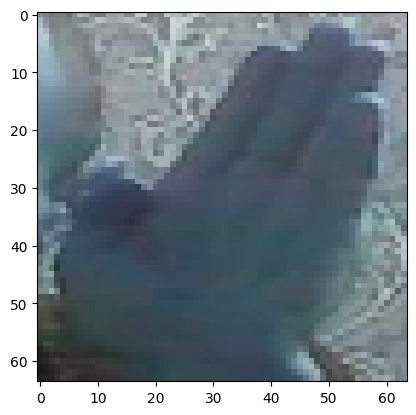

In [8]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [10]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


## Modelle mit verschiedenen Activation Functions der Hidden Layers bauen und vergleichen

In [23]:
# Zu vergleichende Activation Functions
activation_functions_to_test = ['leaky_relu', 'relu', 'tanh', 'sigmoid', 'gelu']

# Ergebnisse der Vergleichsmetriken (für Vergleichsplots)
results = {
    'activation': [],
    'inference_time_per_img': [],
    'metrics': {}
}

# Ergebnisordner erstellen (falls noch nicht geschehen)
for folder in ['models', 'model_summaries', 'conf_matrices', 'training_curves', 'results_activation_function_comparison']:
    os.makedirs(folder, exist_ok=True)

#### Modelle bauen, testen und plotten in Schleife über alle zu testenden Activation Functions

Starte Training für leaky_relu
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 331ms/step - accuracy: 0.4292 - loss: 1.0645 - val_accuracy: 0.5000 - val_loss: 1.0334 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.4444 - loss: 1.0279 - val_accuracy: 0.6484 - val_loss: 0.7394 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.6394 - loss: 0.8388 - val_accuracy: 0.7188 - val_loss: 0.5779 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.8166 - loss: 0.4916 - val_accuracy: 0.7891 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.8535 - loss: 0.3841 - val_accuracy: 0.9141 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - accuracy: 0.9141 - loss: 0.3066 - val_accuracy: 0.9219 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/ste

Summary für leaky_relu
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step


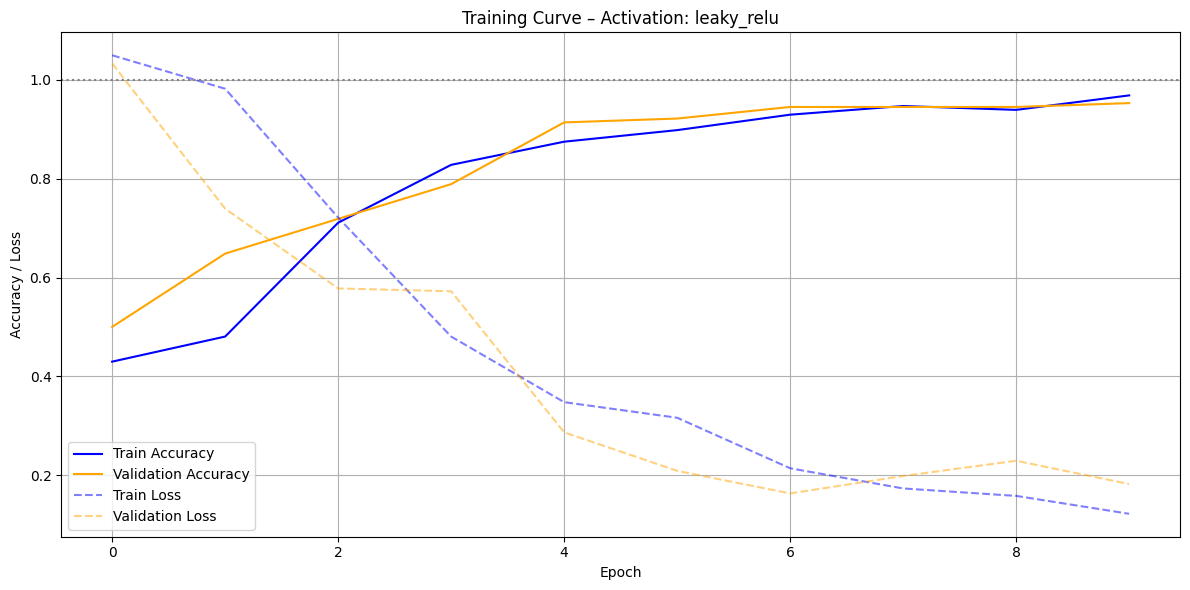

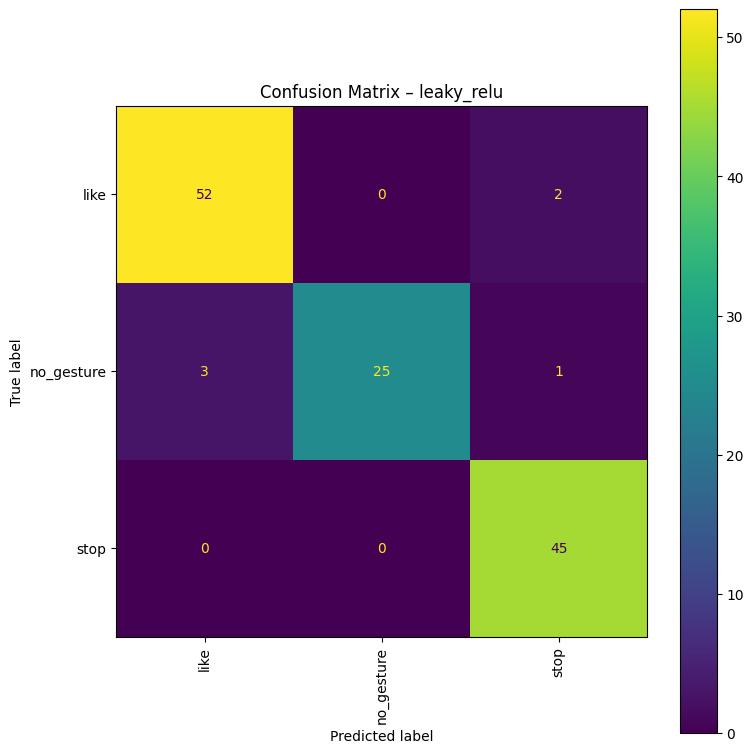

Starte Training für relu
Epoch 1/50


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.4079 - loss: 1.0799 - val_accuracy: 0.3516 - val_loss: 1.0987 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.3895 - loss: 1.0608 - val_accuracy: 0.4297 - val_loss: 1.0591 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.4190 - loss: 1.0389 - val_accuracy: 0.4688 - val_loss: 1.0146 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 258ms/step - accuracy: 0.5471 - loss: 0.9589 - val_accuracy: 0.5234 - val_loss: 0.9926 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.5544 - loss: 0.8931 - val_accuracy: 0.8359 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.7799 - loss: 0.5223 - val_accuracy: 0.8047 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.8357 - loss: 0.3989 - val_

Summary für relu
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step


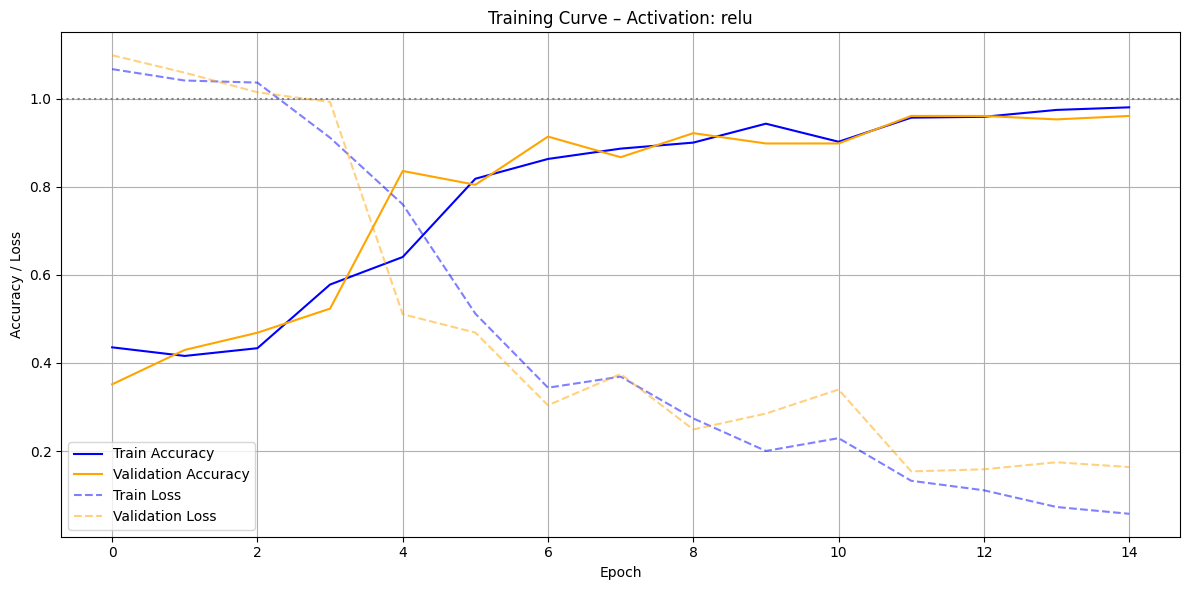

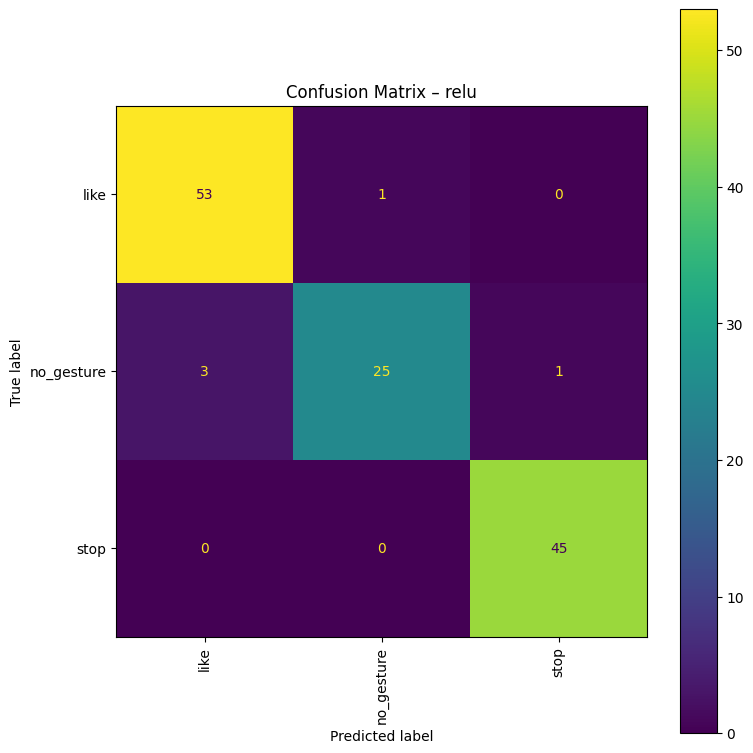

Starte Training für tanh


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 349ms/step - accuracy: 0.4179 - loss: 1.1063 - val_accuracy: 0.4375 - val_loss: 1.0000 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - accuracy: 0.5971 - loss: 0.8972 - val_accuracy: 0.6250 - val_loss: 0.7449 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 287ms/step - accuracy: 0.6756 - loss: 0.7011 - val_accuracy: 0.8516 - val_loss: 0.4487 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - accuracy: 0.8406 - loss: 0.4075 - val_accuracy: 0.9375 - val_loss: 0.2411 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.9356 - loss: 0.2054 - val_accuracy: 0.8906 - val_loss: 0.3069 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.9288 - loss: 0.2170 - val_accuracy: 0.9141 - val_loss: 0.2349 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 277ms/step - accuracy: 0.9564 - loss: 0.

Summary für tanh
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 428ms/step


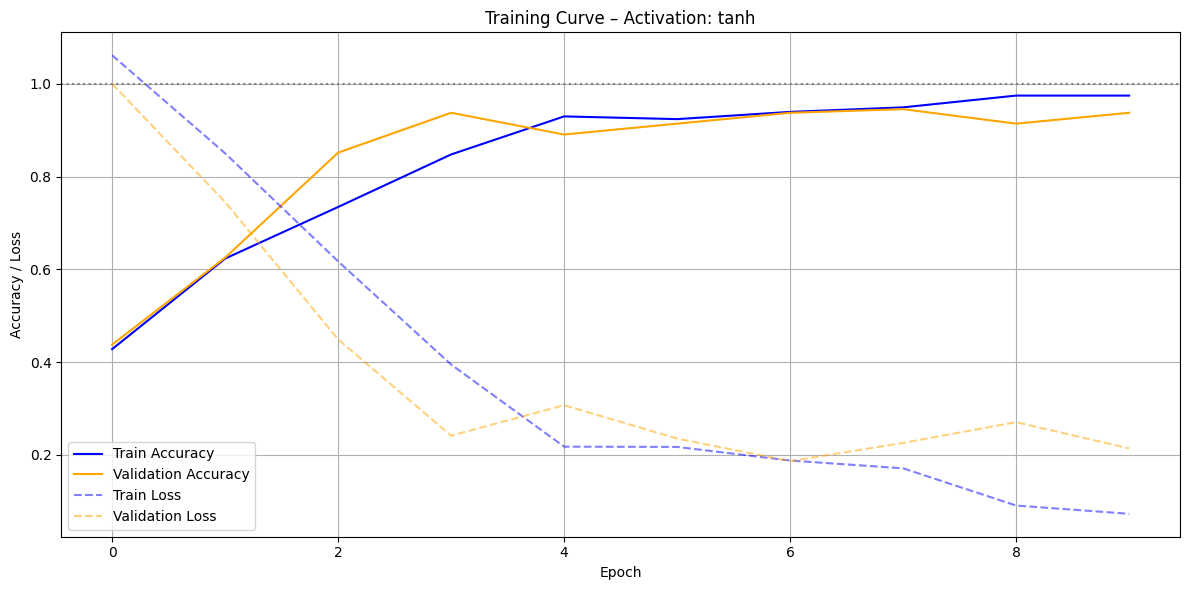

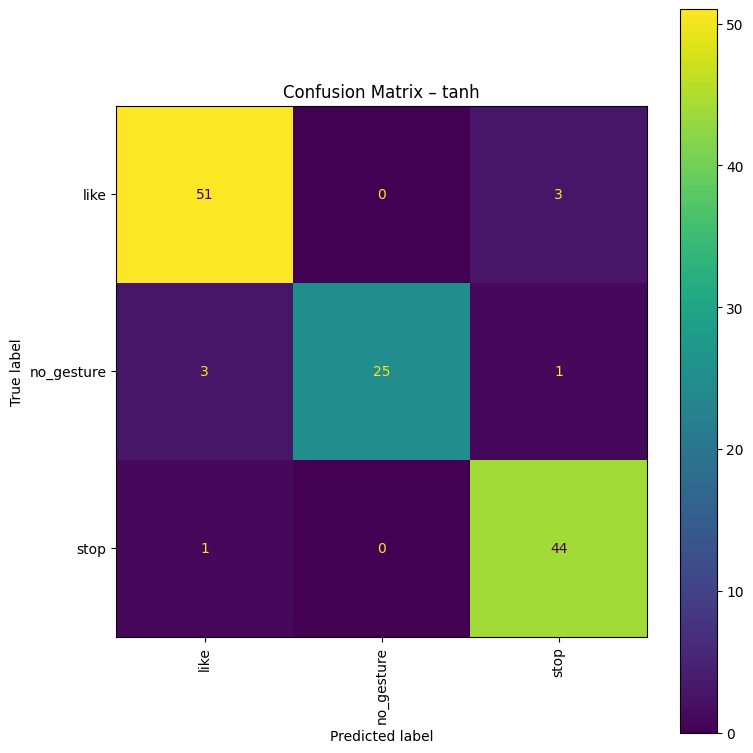

Starte Training für sigmoid


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 369ms/step - accuracy: 0.3439 - loss: 1.1372 - val_accuracy: 0.3516 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.3622 - loss: 1.0878 - val_accuracy: 0.4219 - val_loss: 1.0870 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 333ms/step - accuracy: 0.3312 - loss: 1.0909 - val_accuracy: 0.4219 - val_loss: 1.0677 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step - accuracy: 0.4054 - loss: 1.0754 - val_accuracy: 0.4375 - val_loss: 1.0640 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.3968 - loss: 1.0764 - val_accuracy: 0.4219 - val_loss: 1.0685 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 336ms/step - accuracy: 0.3815 - loss: 1.0878 - val_accuracy: 0.4219 - val_loss: 1.0761 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.3751 - loss: 1.

Summary für sigmoid
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step


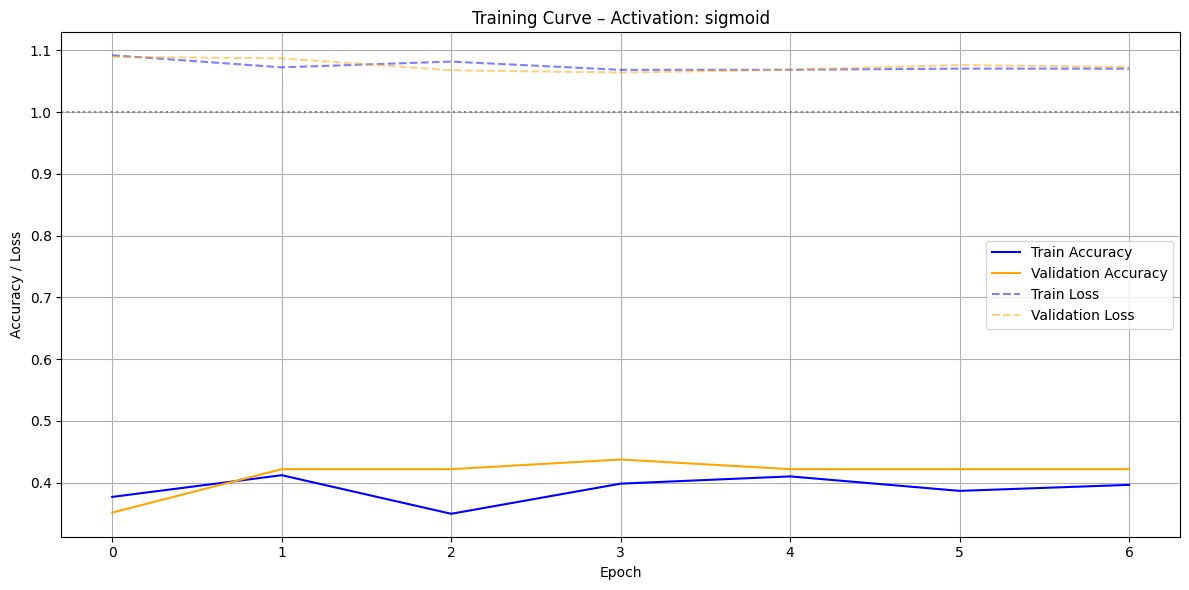

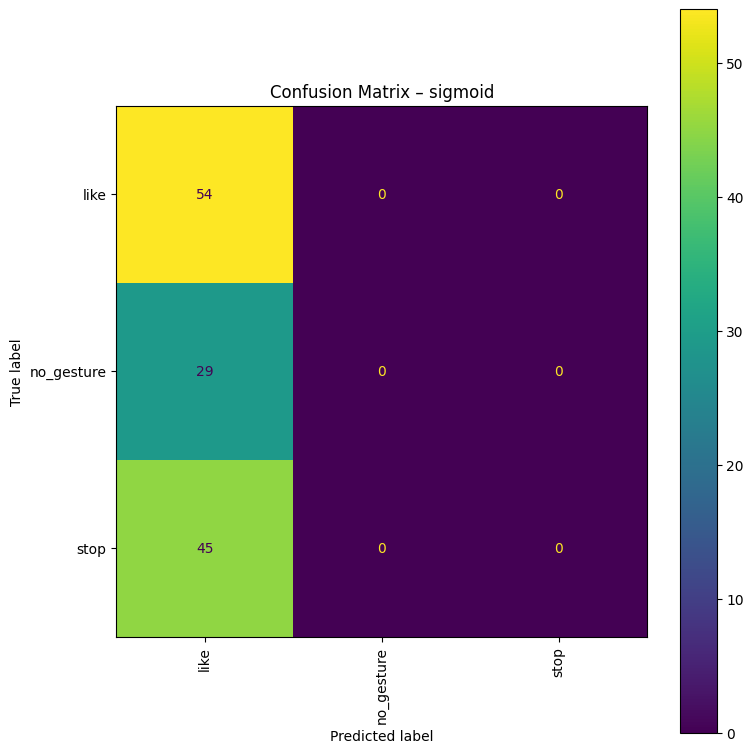

Starte Training für gelu


c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 329ms/step - accuracy: 0.3696 - loss: 1.0746 - val_accuracy: 0.4922 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 271ms/step - accuracy: 0.4952 - loss: 1.0064 - val_accuracy: 0.4062 - val_loss: 1.0510 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.5231 - loss: 0.9927 - val_accuracy: 0.6484 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.6475 - loss: 0.7986 - val_accuracy: 0.8438 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.7520 - loss: 0.6170 - val_accuracy: 0.8828 - val_loss: 0.3695 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.8574 - loss: 0.4368 - val_accuracy: 0.8438 - val_loss: 0.5043 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 384ms/step - accuracy: 0.8735 - loss: 0.

Summary für gelu
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step


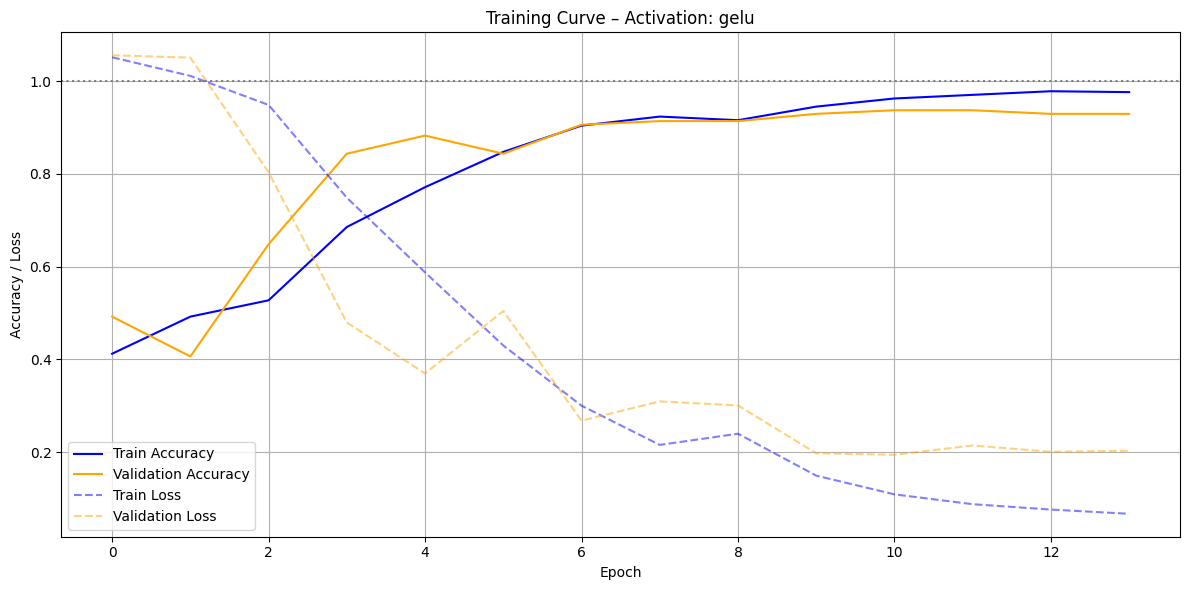

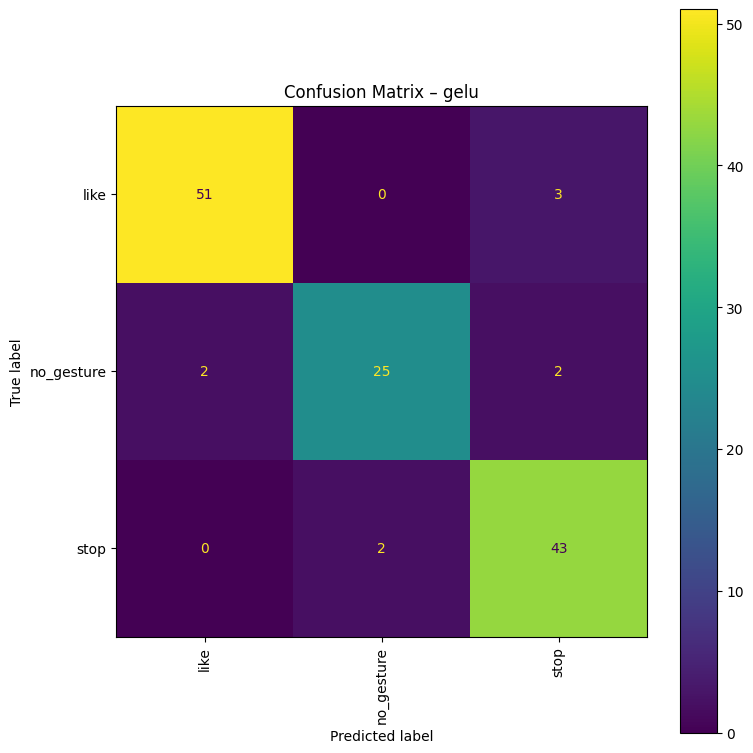

In [24]:
# variables for hyperparameters ##############################################################################
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64


# Über alle Activation Functions iterieren
for activation in activation_functions_to_test:
    
    print(f"Starte Training für {activation}")
    # define model structure ##################################################################################
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    model.add(RandomFlip('horizontal'))
    model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)


    # Training ################################################################################################
    history = model.fit(
        X_train,
        train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, test_label),
        callbacks=[reduce_lr, stop_early]
    )


    # Model speichern #########################################################################################
    model.save(f'models/model_{activation}.keras')


    # Modellinformationen und Performancemetriken speichern ###################################################
    
    # Summary
    lines = []
    model.summary(print_fn=lambda x: lines.append(x))
    print(f"Summary für {activation}")
    with open(f'model_summaries/model_summary_{activation}.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(lines))

    # Inference Time messen
    start = time()
    y_predictions = model.predict(X_test)
    end = time()
    inference_time = end - start
    inference_time_per_img = inference_time / len(X_test)

    # Plot Loss & Accuracy Verlauf pro Funktion
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    fig = plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Train Accuracy', color='blue')
    plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
    plt.plot(loss, '--', label='Train Loss', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', label='Validation Loss', color='orange', alpha=0.5)
    plt.axhline(1, color='gray', linestyle=':')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / Loss')
    plt.title(f'Training Curve – Activation: {activation}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'training_curves/training_curve_{activation}.png')
    plt.show()

    # Confusion Matrix
    y_predictions_argmax = np.argmax(y_predictions, axis=1)
    conf_matrix = confusion_matrix(y_test, y_predictions_argmax)
    fig = plt.figure(figsize=(8, 8))
    ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())
    plt.title(f'Confusion Matrix – {activation}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'conf_matrices/confusion_matrix_{activation}.png')
    plt.show()

    # Inference Time und History in results speichern
    results['activation'].append(activation)
    results['inference_time_per_img'].append(inference_time_per_img)
    results['metrics'][activation] = history.history

#### Ergebnisse des Funktionsvergleichs visualisieren

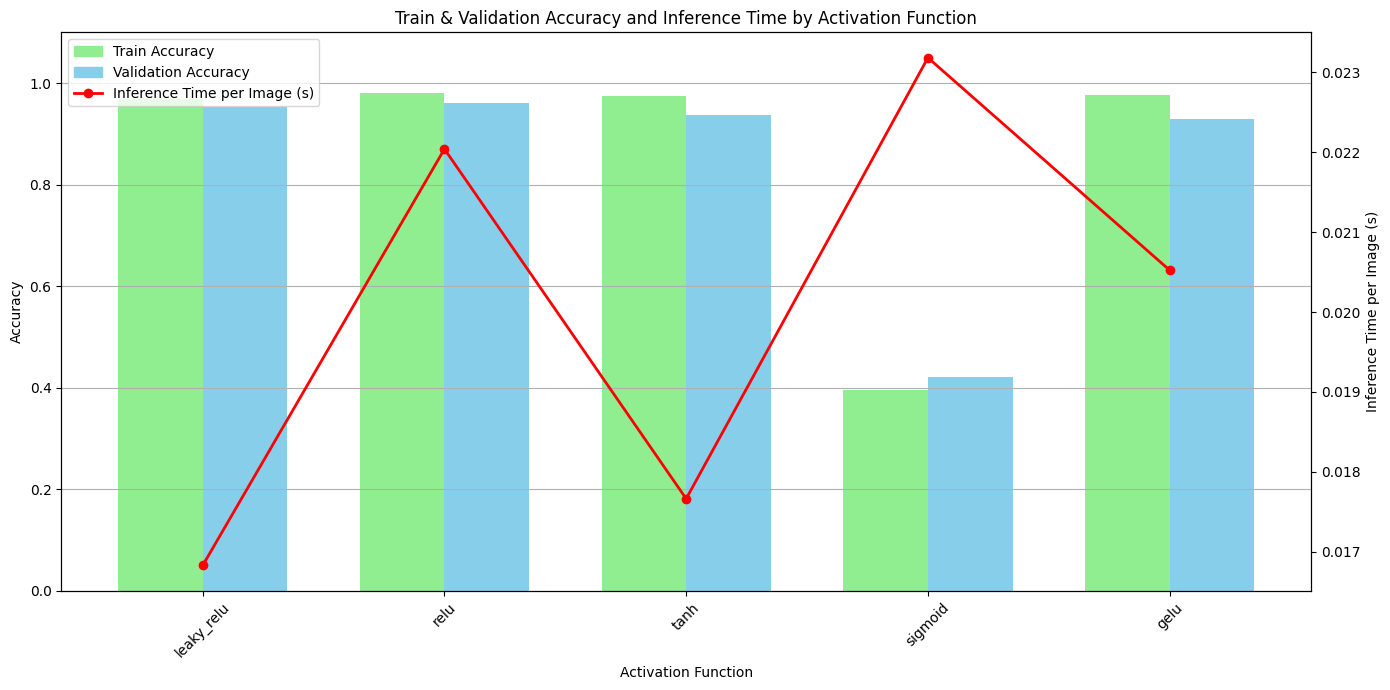

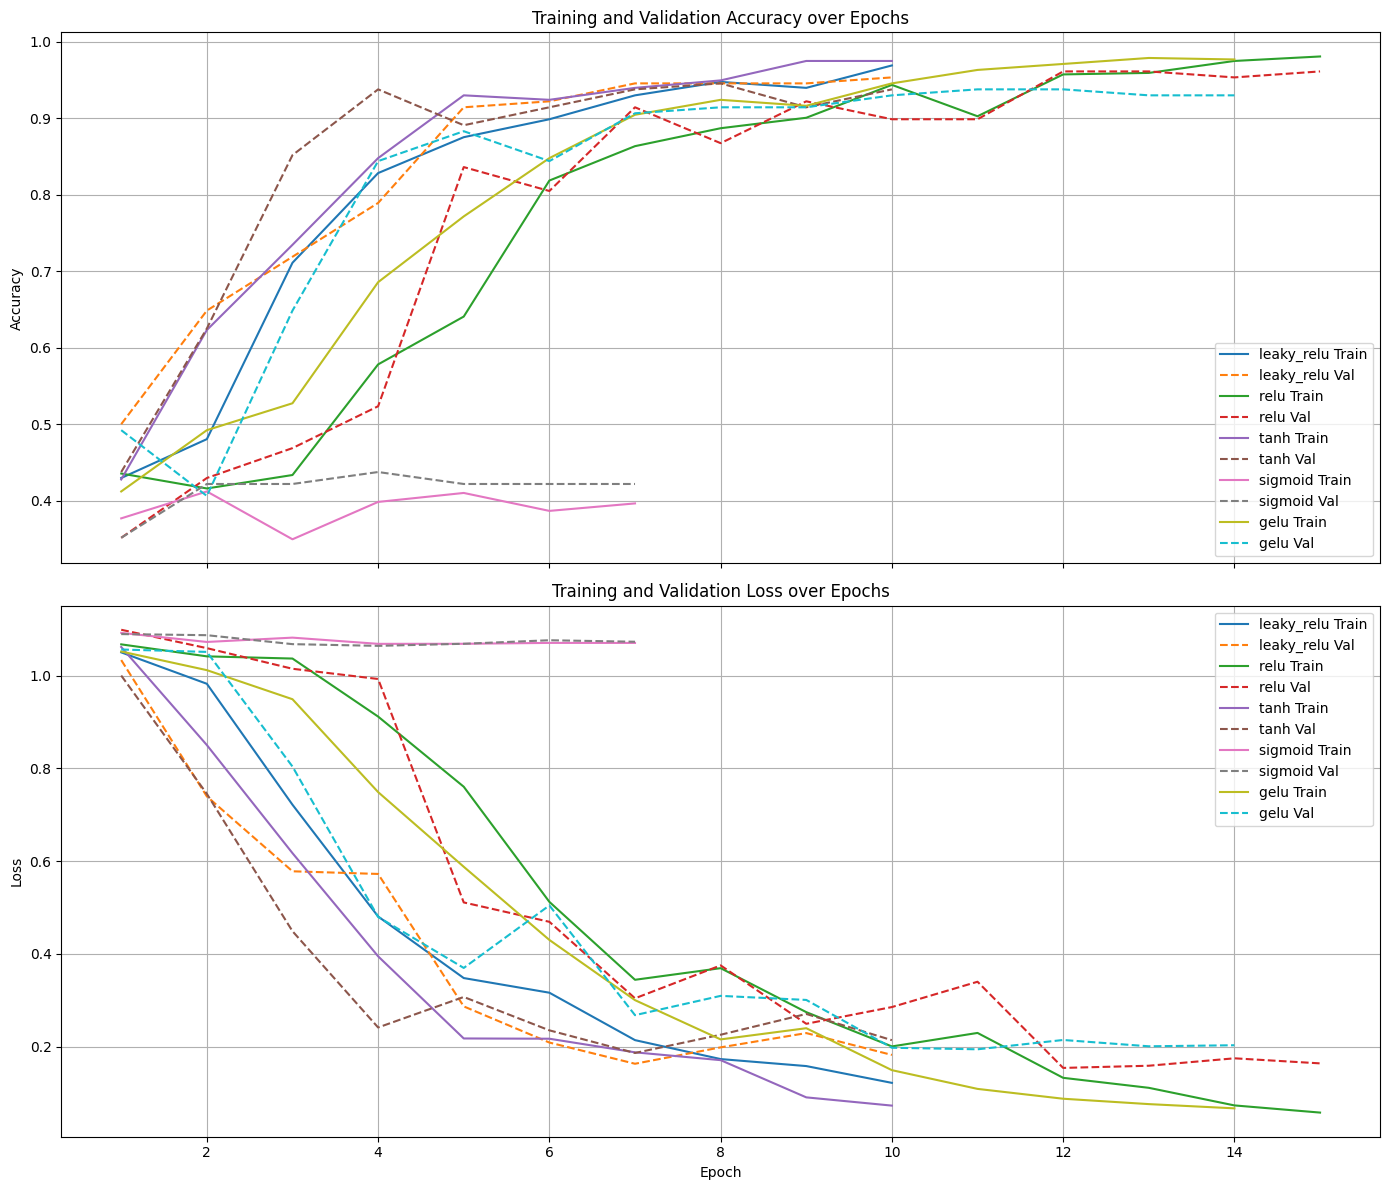

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import os

# Speicherpfad
output_dir = "results_activation_function_comparison"
os.makedirs(output_dir, exist_ok=True)


# DataFrame ohne history / metrics (weil das in Dict ist, das nicht in einen df passt)
final_train_accuracies = []
final_val_accuracies = []

for activation in results['activation']:
    history = results['metrics'][activation]
    final_train_accuracies.append(history['accuracy'][-1])
    final_val_accuracies.append(history['val_accuracy'][-1])

df_results = pd.DataFrame({
    'activation': results['activation'],
    'inference_time_per_img': results['inference_time_per_img'],
    'train_accuracy': final_train_accuracies,
    'val_accuracy': final_val_accuracies
})


# Plot: Train & Validation Accuracy + Inference Time ####################################################

fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()

x = np.arange(len(df_results['activation']))
width = 0.35

# Balken
bars1 = ax1.bar(x - width/2, df_results['train_accuracy'], width, color='lightgreen')
bars2 = ax1.bar(x + width/2, df_results['val_accuracy'], width, color='skyblue')

# Linie
line = ax2.plot(x, df_results['inference_time_per_img'], color='red', marker='o', linewidth=2)

# Achsenbeschriftung
ax1.set_xlabel('Activation Function')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Inference Time per Image (s)')
ax1.set_xticks(x)
ax1.set_xticklabels(df_results['activation'], rotation=45)
ax1.set_ylim(0, 1.1)

# Manuelle Legenden-Handles
legend_handles = [
    mpatches.Patch(color='lightgreen', label='Train Accuracy'),
    mpatches.Patch(color='skyblue', label='Validation Accuracy'),
    Line2D([0], [0], color='red', marker='o', label='Inference Time per Image (s)', linewidth=2)
]

ax1.legend(handles=legend_handles, loc='upper left')

plt.title('Train & Validation Accuracy and Inference Time by Activation Function')
ax1.grid(axis='y')
plt.tight_layout()

# Speichern
plot_accuracy_inference_path = os.path.join(output_dir, "plot_accuracy_inference.png")
plt.savefig(plot_accuracy_inference_path)
plt.show()


# Plot: Accuracy & Loss Verlauf pro Activation Function ##################################################

fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

for activation in df_results['activation']:
    history = results['metrics'][activation]
    epochs = range(1, len(history['accuracy']) + 1)

    axes[0].plot(epochs, history['accuracy'], label=f"{activation} Train", linestyle='-')
    axes[0].plot(epochs, history['val_accuracy'], label=f"{activation} Val", linestyle='--')

    axes[1].plot(epochs, history['loss'], label=f"{activation} Train", linestyle='-')
    axes[1].plot(epochs, history['val_loss'], label=f"{activation} Val", linestyle='--')

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training and Validation Accuracy over Epochs')
axes[0].legend(loc='lower right')
axes[0].grid()

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Training and Validation Loss over Epochs')
axes[1].legend(loc='upper right')
axes[1].grid()

plt.tight_layout()

# Speichern
plot_loss_accuracy_per_epoch_path = os.path.join(output_dir, "plot_loss_accuracy_per_epoch.png")
plt.savefig(plot_loss_accuracy_per_epoch_path)
plt.show()


# Export der Metriken als CSV ###########################################################################

df_summary = df_results.copy()
df_summary = df_summary.rename(columns={
    'train_accuracy': 'final_train_accuracy',
    'val_accuracy': 'final_val_accuracy'
})

# Runden für Übersicht
df_summary = df_summary.round({
    'final_train_accuracy': 4,
    'final_val_accuracy': 4,
    'inference_time_per_img': 6
})

csv_path = os.path.join(output_dir, "activation_summary.csv")
df_summary.to_csv(csv_path, index=False)


## let's test our model in action

In [26]:
# Meine Webcam wollte nicht, also habe ich ein Testscript eingebaut, um den Fehler abzufangen
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Kamera konnte nicht geöffnet werden.")
ret, frame = cap.read()
cap.release()

if not ret:
    print("Fehler beim Einlesen des Kamerabildes.")
else:
    if COLOR_CHANNELS == 1:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    plt.imshow(frame, cmap='gray' if COLOR_CHANNELS == 1 else None)
    plt.axis('off')
    plt.show()

Fehler beim Einlesen des Kamerabildes.


## manual cropping for demonstration purposes - you can do better!

In [ ]:
plt.imshow(frame[50:350, 60:210])

In [ ]:
resized = cv2.resize(frame[50:350, 60:210], SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [ ]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

In [ ]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j]
        axes[i][j].imshow(img)

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [ ]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass